### Fig yeast depletion (Fig 6)
- 6A: Plot a representation of the probe selection pipeline
- 6B: Plot the probe selection process for 25S transcript
- 6C: Plot the qPCR test of the yeast probes

In [1]:
#Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0)
import os
import gffutils
import seaborn as sns
import numpy as np
import scipy.stats
import itertools

sys.path.append('../scripts/')
from plot_helpers import *
import analyze_qpcr_plate

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Make outdir and load the data
outdir = '../figures/F6/'
os.makedirs(outdir, exist_ok = True)

In [3]:
#Load data
thisdir = os.path.join(results_dir, 'probe_design_results/yeast_200729/probe_design/')
df = pd.read_csv(os.path.join(thisdir, '25S/potential_probes_filt.csv'))
final_df = pd.read_csv(os.path.join(thisdir, 'all_selected_probes.csv'))
final_df = final_df[final_df['target_name'] == '25S'].copy()
df['midpt'] = df['target_start'] + df['length']/2
df.sort_values(by = 'midpt', ascending = True, inplace = True)

In [4]:
#choose the highest Tm probe at each start site:
idx = df.groupby(['start'])['Tm'].transform(max) == df['Tm']
df = df[idx].copy()
start_range = np.arange(df['midpt'].min() - 1, df['midpt'].max()+ 2, 0.5)
range_df = pd.DataFrame(start_range, columns = ['midpt'])
new_df = pd.merge(range_df[['midpt']], df[['unique_id', 'Tm', 'midpt']], 'outer', on = 'midpt')

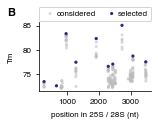

In [5]:
#6B: Plot the selected probes for the 25S/28S in Scer/Spom
panel_name = '6B'
plot = Plotter(corners = [0.21, 0.27, 0.74, 0.60], figsize = (sfig*1.3, sfig))
plot.nudge_corners(top = True, right = True)
plot.setup_axis()

df['midpt'] = df['target_start'] + df['length']/2
df.sort_values(by = 'midpt', ascending = True, inplace = True)

bg = plot.ax.scatter(new_df['midpt'], new_df['Tm'], color = selected_colors[0], alpha = 0.5, s = 10, edgecolors = 'none')
mini_df = new_df[new_df['unique_id'].isin(final_df['unique_id'].values)].copy()
selected = plot.ax.scatter(mini_df['midpt'], mini_df['Tm'], color = selected_colors[3], s = 10, edgecolors = 'none')

plot.ax.legend([bg, selected], ['considered', 'selected'], 
               mode = 'expand', fontsize = 8, ncol = 3, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, 
               borderaxespad=0., handletextpad = -0.2)


plot.set_ylabel('Tm')
plot.set_xlabel('position in 25S / 28S (nt)')
plot.add_letter('B')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

In [6]:
#6C: Plot the qPCR test for the yeast probes
qpcr_dir = os.path.join(results_dir, 'qPCR_data')

yeast_data = ['200723_yeast_repeat/20200723_141719_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx']
yeast_template = ['200723_yeast_repeat/qPCR_analysis_template_yeast_repeat.xlsx']

exps = {'data': [os.path.join(qpcr_dir, i) for i in yeast_data],
       'templates': [os.path.join(qpcr_dir, i) for i in yeast_template]}

df_list = []
for i in range(0, len(exps['data'])):
    df_list.append(analyze_qpcr_plate.main(exps['data'][i], exps['templates'][i], 'scerAct1'))
df = pd.concat(df_list)

these_samples = ['y100ng_r1', 'y100ng_r2', 'y100ng_r3']
sum_df = df.loc[pd.IndexSlice[['scer18S', 'scer25_2'],:, these_samples],].droplevel('denominator').copy()
sum_df['input'], sum_df['rep'] = zip(*sum_df.index.get_level_values('sample').map(lambda x: x.rsplit('_', 1)))
sum_df['percent_remaining'] = sum_df['fold_change']*100
sum_df['primer_name'] = sum_df.index.get_level_values('primer').map({'scer18S':'18S', 'scer25_2': '25S'})

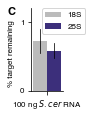

In [7]:
#Fig 3: plot the percent remaining at different input levels:
#https://stackoverflow.com/questions/5735208/remove-the-legend-on-a-matplotlib-figure
panel_name = '6C'
loc = plticker.MultipleLocator(base=1.0)
##plot = Plotter(corners = [0.24, 0.24, 0.35, 0.71], figsize = (sfig*0.7, sfig))
plot = Plotter(corners = [0.3, 0.27, 0.4, 0.71], figsize = (sfig*0.7, sfig))
plot.nudge_corners(top = True, right = True)
#plot.nudge_corners(left = True, right = True)
plot.setup_axis()
plot.ax = sns.barplot(x="input", y="percent_remaining", hue="primer_name", data = sum_df.reset_index(), 
                      ci = 'sd', ax = plot.ax, palette = [selected_colors[0], selected_colors[3]])
plot.set_ylabel('% target remaining', nudge = (0, -0.03))
plot.set_xlabel('')
plot.add_letter('C')
plot.ax.set_xticklabels(['100 ng 'r'$S. cer$'' RNA'])
plot.ax.set_ylim(0, 1.2)
#plt.legend(loc = 'best', ncol = 1, fontsize = label_fontsize)
plt.legend(bbox_to_anchor = (1.85, 1.05), ncol = 1, fontsize = label_fontsize)

#leg = plot.ax.get_legend().set_visible(False)
plot.ax.yaxis.set_major_locator(loc)
#seaborn is not respecting rcparams for linewidth, so change it here:
lines = plot.ax.lines
for line in lines:
    line.set_linewidth(0.75)
    line.set_color('k')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

In [8]:
sum_df

ddCt  fold_change   input rep  percent_remaining  \
primer   sample                                                            
scer18S  y100ng_r1  7.303668     0.006330  y100ng  r1           0.632961   
         y100ng_r2  7.461147     0.005675  y100ng  r2           0.567507   
         y100ng_r3  6.686767     0.009707  y100ng  r3           0.970695   
scer25_2 y100ng_r1  7.830380     0.004394  y100ng  r1           0.439360   
         y100ng_r2  7.373095     0.006032  y100ng  r2           0.603222   
         y100ng_r3  7.138351     0.007098  y100ng  r3           0.709810   

                   primer_name  
primer   sample                 
scer18S  y100ng_r1         18S  
         y100ng_r2         18S  
         y100ng_r3         18S  
scer25_2 y100ng_r1         25S  
         y100ng_r2         25S  
         y100ng_r3         25S